In [ ]:
!pip install obspy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import obspy
from obspy import read, UTCDateTime
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from obspy.signal.trigger import classic_sta_lta, recursive_sta_lta
from obspy.signal.filter import envelope
from scipy.stats import kurtosis, skew
from google.colab import drive
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pickle

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def read_stream(filename, sampling_rate):
  stream = read(filename, debug_header=True)
  stream = stream.select(sampling_rate=sampling_rate)

  station = ""
  for trace in stream:
    if station == trace.stats.station:
      stream.remove(trace)
    station = trace.stats.station

  return stream

In [ ]:
trace = read("/content/2021.06.27.22.15.10.GBJIZ.sac")
trace[0].stats

t1 = trace[0].stats.starttime

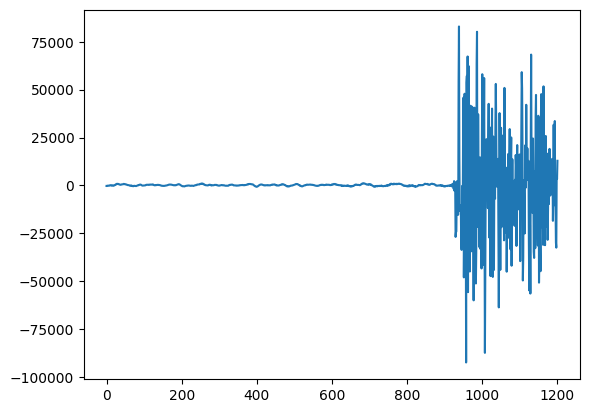

In [ ]:
plt.plot(trace.slice(t1, t1+60)[0].data)

In [ ]:
path_rawData = "drive/MyDrive/data/training/rawDataNew"
files = os.listdir(path_rawData)
len(files)

86

In [ ]:
tr = read(path_rawData+'/'+files[0])
tr[0].stats

         network: II
         station: KAPI
        location: 00
         channel: BHZ
       starttime: 2018-12-29T03:41:12.019539Z
         endtime: 2018-12-29T03:46:35.994539Z
   sampling_rate: 40.0
           delta: 0.025
            npts: 12960
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'M', 'number_of_records': 6, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 4096, 'filesize': 24576})

In [ ]:
os.remove(path_rawData+'/'+files[33])

In [ ]:
def runningKurt(x, N):
    y = np.zeros((len(x) - (N - 1),))
    for i in range(len(x) - (N - 1)):
         y[i] = kurtosis(x[i:(i + N)])
    return y

def runningSkew(x, N):
    y = np.zeros((len(x) - (N - 1),))
    for i in range(len(x) - (N - 1)):
         y[i] = skew(x[i:(i + N)])
    return y

def preprocess_non_filter(stream):
  for i in range(len(stream)):
    stream[i] = stream[i].normalize()
  return stream

def preprocess_filter(stream, freq, corners):
  for i in range(len(stream)):
    stream[i] = stream[i].filter('lowpass', freq=freq, corners=corners, zerophase=True).normalize()
  return stream

def preprocess_filter_band(stream, freq1, freq2, corners):
  for i in range(len(stream)):
    stream[i] = stream[i].filter('bandpass', freqmin=freq1, freqmax=freq2, corners=corners, zerophase=True).normalize()
  return stream

def make_parameters(stream, sta, lta, sampling_rate):
  stream_value = stream[0].data
  traces_classic_sta_lta = classic_sta_lta(stream[0], int(sta*sampling_rate), int(lta*sampling_rate))
  traces_recursive_sta_lta = recursive_sta_lta(stream[0], int(sta*sampling_rate), int(lta*sampling_rate))
  traces_envelope = envelope(stream[0].data)
  traces_kurtosis = list(runningKurt(stream[0].data, 360))
  traces_kurtosis[:0] = [0 for i in range(len(traces_kurtosis), len(stream[0].data), 1)]
  traces_skewness = list(runningSkew(stream[0].data, 360))
  traces_skewness[:0] = [0 for i in range(len(traces_skewness), len(stream[0].data), 1)]

  return stream_value, traces_classic_sta_lta, traces_recursive_sta_lta, traces_envelope, traces_kurtosis, traces_skewness

In [ ]:
def plot_stream(stream):
  plt.figure(figsize=(20,5))
  for i in range(len(stream)):
    plt.subplot(len(stream), 1, i + 1)
    plt.plot(stream[i], color='black')
    #plt.legend()
  plt.show()

In [ ]:
plot_stream(files)

In [ ]:
def multiplot(stream, traces_classic_sta_lta, traces_recursive_sta_lta, traces_envelope, traces_kurtosis, traces_skewness, p, s):
  plt.figure(figsize=(12,8))

  plt.subplot(6,1,1)
  plt.plot(stream[0].data, label='Trace', color='black')
  plt.axvline(x= p, linewidth=1, color='red')
  plt.axvline(x= s, linewidth=1, color='purple')
  #plt.axvline(x= p-300, linewidth=1, color='blue')
  #plt.axvline(x= p+300, linewidth=1, color='blue')
  #plt.axvline(x= s-300, linewidth=1, color='blue')
  #plt.axvline(x= s+300, linewidth=1, color='blue')
  plt.legend()

  plt.subplot(6,1,2)
  plt.plot(traces_classic_sta_lta, label='Classic STA/LTA', color='black')
  plt.axvline(x= p, linewidth=1, color='red')
  plt.axvline(x= s, linewidth=1, color='purple')
  #plt.axvline(x= p-300, linewidth=1, color='blue')
  #plt.axvline(x= p+300, linewidth=1, color='blue')
  #plt.axvline(x= s-300, linewidth=1, color='blue')
  #plt.axvline(x= s+300, linewidth=1, color='blue')
  plt.legend()

  plt.subplot(6,1,3)
  plt.plot(traces_recursive_sta_lta, label='Recursive STA/LTA', color='black')
  plt.axvline(x= p, linewidth=1, color='red')
  plt.axvline(x= s, linewidth=1, color='purple')
  #plt.axvline(x= p-300, linewidth=1, color='blue')
  #plt.axvline(x= p+300, linewidth=1, color='blue')
  #plt.axvline(x= s-300, linewidth=1, color='blue')
  #plt.axvline(x= s+300, linewidth=1, color='blue')
  plt.legend()

  plt.subplot(6,1,4)
  plt.plot(traces_envelope, label='Envelope', color='black')
  plt.axvline(x= p, linewidth=1, color='red')
  plt.axvline(x= s, linewidth=1, color='purple')
  #plt.axvline(x= p-300, linewidth=1, color='blue')
  #plt.axvline(x= p+300, linewidth=1, color='blue')
  #plt.axvline(x= s-300, linewidth=1, color='blue')
  #plt.axvline(x= s+300, linewidth=1, color='blue')
  plt.legend()

  plt.subplot(6,1,5)
  plt.plot(traces_kurtosis, label='Kurtosis', color='black')
  plt.axvline(x= p, linewidth=1, color='red')
  plt.axvline(x= s, linewidth=1, color='purple')
  #plt.axvline(x= p-300, linewidth=1, color='blue')
  #plt.axvline(x= p+300, linewidth=1, color='blue')
  #plt.axvline(x= s-300, linewidth=1, color='blue')
  #plt.axvline(x= s+300, linewidth=1, color='blue')
  plt.legend()

  plt.subplot(6,1,6)
  plt.plot(traces_skewness, label='Skewness', color='black')
  plt.axvline(x= p, linewidth=1, color='red')
  plt.axvline(x= s, linewidth=1, color='purple')
  #plt.axvline(x= p-300, linewidth=1, color='blue')
  #plt.axvline(x= p+300, linewidth=1, color='blue')
  #plt.axvline(x= s-300, linewidth=1, color='blue')
  #plt.axvline(x= s+300, linewidth=1, color='blue')
  plt.legend()

In [ ]:
def write_csv(traces_classic_sta_lta, traces_recursive_sta_lta, traces_envelope, traces_kurtosis, traces_skewness, path, index_stream, index_fb, mode, header):
  classic_sta_lta_value = []
  recursive_sta_lta_value = []
  envelope_value = []
  kurtosis_value = []
  skewness_value = []
  label = []

  for index in range(index_fb-50, index_fb+51, 1):
    classic_sta_lta_value.append(traces_classic_sta_lta[index])
    recursive_sta_lta_value.append(traces_recursive_sta_lta[index])
    envelope_value.append(traces_envelope[index])
    kurtosis_value.append(traces_kurtosis[index])
    skewness_value.append(traces_skewness[index])
    if index == index_fb:
      label.append(1)
    else:
      label.append(0)

  data = {'classic STA/LTA' : classic_sta_lta_value,
      'recursive STA/LTA' : recursive_sta_lta_value,
      'envelope' : envelope_value,
      'kurtosis' : kurtosis_value,
      'skewness' : skewness_value,
      'label' : label
      }

  df = pd.DataFrame(data)

  with open(path, mode, encoding='utf-8-sig') as f:
    df.to_csv(f, header=header, index=False)

In [ ]:
tr1 = read("/content/drive/MyDrive/data/training/rawDataNew/HK.HKPS.00.BHZ_2018-09-28T10_06_49.160_2018-09-28T10_14_01.238.mseed")
tr2 = read("/content/drive/MyDrive/data/training/rawDataNew/IC.ENH.00.BHZ_2018-12-29T03_44_06.955_2018-12-29T03_51_57.066.mseed")
tr3 = read("/content/drive/MyDrive/data/training/rawDataNew/II.KAPI.00.BHZ_2019-04-23T05_40_55.064_2019-04-23T05_47_11.571.mseed")
#tr1_filter = preprocess(tr1, 1, 3)
#tr2_filter = preprocess(tr2, 1, 3)
#tr3_filter = preprocess(tr3, 1, 3)
plt.figure(figsize=(20,7))
plt.subplot(321)
#plt.plot(tr1[0].data, color='black')
plt.subplot(322)
plt.plot(tr1_filter[0].data, color='black')
plt.subplot(323)
#plt.plot(tr2[0].data, color='black')
plt.subplot(324)
plt.plot(tr2_filter[0].data, color='black')
plt.subplot(325)
#plt.plot(tr3[0].data, color='black')
plt.subplot(326)
plt.plot(tr3_filter[0].data, color='black')
print(tr1[0].data)

In [ ]:
sta = 2
lta = 30

traces_classic_sta_lta, traces_recursive_sta_lta, traces_envelope, traces_kurtosis, traces_skewness = make_parameters(stream, sta, lta, 40)

In [ ]:
index_fb = 2333                    # atur value hingga terdapat hubungan antara klasik, recursive, envelope, kurtosis, dan skewness

index_non_p1 = index_fb - 100
index_non_p2 = index_fb + 100

multiplot(stream, traces_classic_sta_lta,
          traces_recursive_sta_lta, traces_envelope,
          traces_kurtosis, traces_skewness,
          index_non_fb1, index_fb, index_non_fb2)

In [ ]:
index_stream = 120
trace = files[index_stream]
stream = read(path_rawData+"/"+trace)
preprocess(stream, 1, 3)
plt.figure(figsize=(20,5))
plt.plot(stream[0].data, label='Filtering & Normalized', color='black')
plt.legend()

2 Trace(s) in Stream:
II.COCO.00.BHZ | 2023-04-14T09:55:45.019536Z - 2023-04-14T10:03:46.994536Z | 40.0 Hz, 19280 samples
II.COCO.10.BHZ | 2023-04-14T09:55:45.019538Z - 2023-04-14T10:03:46.994538Z | 40.0 Hz, 19280 samples


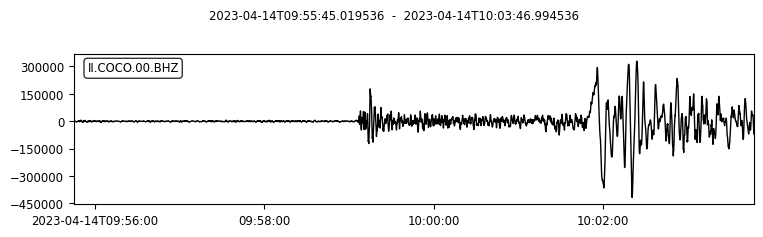

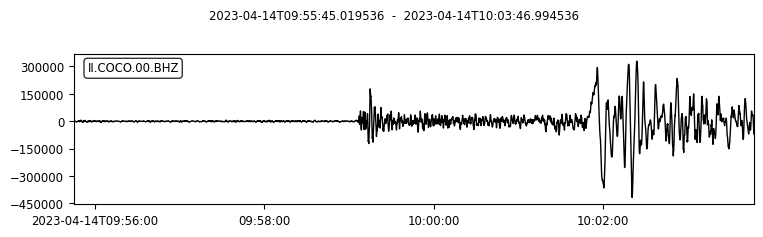

In [ ]:
stream = read("/content/2023-04-14-mww70-java-indonesia.miniseed")
#stream = stream.select(station='WRAB')
print(stream)
stream[0].plot()

In [ ]:
'''
index_stream = 26
trace = files[index_stream]
stream = read(path_rawData+"/"+trace)
'''
stream = read("/content/2021.06.27.22.15.23.BKJIZ.sac").resample(40)
t1 = stream[0].stats.starttime
stream = stream.slice(t1, t1+75)
#stream = stream.select(id='IU.DAV.00.BHZ')
print(stream)
stream = preprocess_filter_band(stream, 0.5, 2.5, 3)

sta = 2
lta = 30

traces_classic_sta_lta, traces_recursive_sta_lta, traces_envelope, traces_kurtosis, traces_skewness = make_parameters(stream, sta, lta, 40)

print(np.argsort(traces_kurtosis)[::-1][:100])

1 Trace(s) in Stream:
IA.BKJI..BHZ | 2021-06-27T22:15:23.321860Z - 2021-06-27T22:16:38.321860Z | 40.0 Hz, 3001 samples
[1666 1665 1667 1664 1668 1669 1663 1670 1671 1662 1683 1684 1682 1672
 1685 1681 1673 1686 1674 1675 1676 1687 1677 1661 1680 1678 1688 1679
 1689 1690 1691 1692 1693 1694 1695 1696 1660 1697 1698 1699 1643 1642
 1644 1641 1645 1640 1700 1639 1638 1646 1637 1636 1635 1701 1634 1647
 1633 1702 1632 1648 1703 1704 1706 1705 1707 1631 1708 1659 1649 1709
 1710 1630 1650 1711 1651 1712 1652 1653 1654 1655 1629 1656 1658 1713
 1657 1714 1715 1716 1717 1718 1719 1720 1628 1721 1722 1723 1724 1738
 1737 1725]


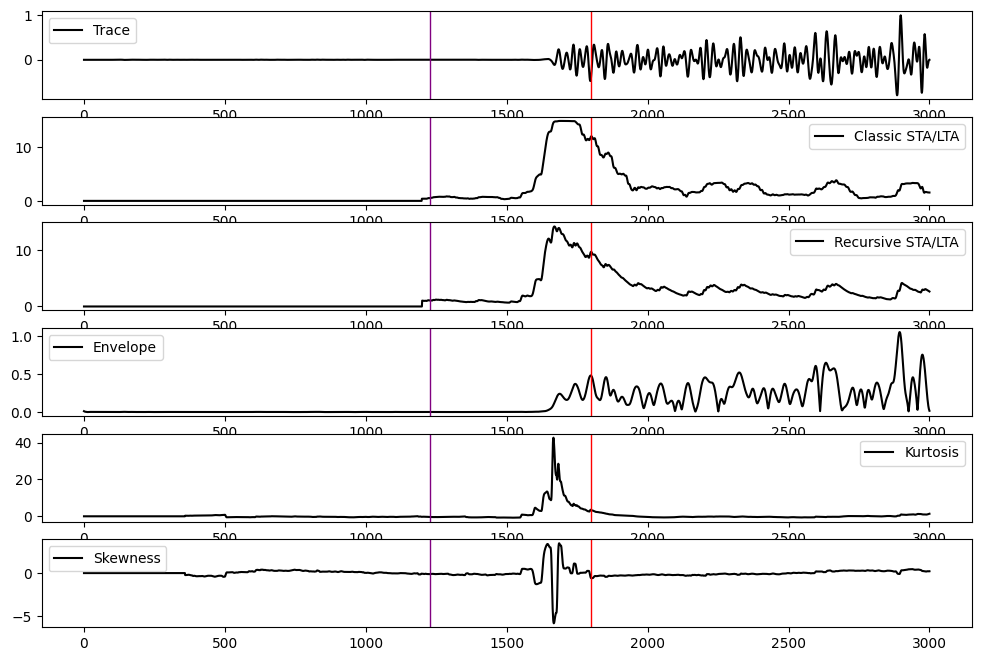

In [ ]:
p = 1800                             # atur value hingga terdapat hubungan antara klasik, recursive, envelope, kurtosis, dan skewness
#s = int(stream[0].stats.npts) - 4800
s = 1226

multiplot(stream, traces_classic_sta_lta,
          traces_recursive_sta_lta, traces_envelope,
          traces_kurtosis, traces_skewness, p, s)

arr = [p, s]

In [ ]:
print(s)

12920


In [ ]:
time = np.linspace(0, len(stream[0]), len(stream[0]))
time

array([0.00000000e+00, 1.00005531e+00, 2.00011063e+00, ...,
       1.80779999e+04, 1.80789999e+04, 1.80800000e+04])

In [ ]:
len(time)

18080

In [ ]:
classic_sta_lta_value = []
recursive_sta_lta_value = []
envelope_value = []
kurtosis_value = []
skewness_value = []
label = []
stream_value = []
#time_value = []

In [ ]:
for index in range(len(stream[0].data)):
  #time_value.append(time[index])
  stream_value.append(stream[0].data[index])
  classic_sta_lta_value.append(traces_classic_sta_lta[index])
  recursive_sta_lta_value.append(traces_recursive_sta_lta[index])
  envelope_value.append(traces_envelope[index])
  kurtosis_value.append(traces_kurtosis[index])
  skewness_value.append(traces_skewness[index])
  if index < p:
    label.append(0.0)
  elif p <= index < s:
    label.append(1.0)
  else:
    label.append(2.0)

In [ ]:
data = {#'time' : time_value,
      'trace' : stream_value,
      'classic STA/LTA' : classic_sta_lta_value,
      'recursive STA/LTA' : recursive_sta_lta_value,
      'envelope' : envelope_value,
      'kurtosis' : kurtosis_value,
      'skewness' : skewness_value,
      'label' : label
      }

df = pd.DataFrame(data)

In [ ]:
df

In [ ]:
path_dataset = '/content/drive/MyDrive/data/training/dataset_training_kirikanan50.csv'
mode = 'w'
header = True

write_csv(traces_classic_sta_lta, traces_recursive_sta_lta, traces_envelope, traces_kurtosis, traces_skewness, path_dataset, index_stream, index_fb, mode, header)

In [ ]:
path_dataset = '/content/drive/MyDrive/data/training/dataset_training_2018-2022.csv'
mode = 'w'
header = True
with open(path_dataset, mode, encoding='utf-8-sig') as f:
    df_merge.to_csv(f, header=header, index=False)

In [ ]:
path = '/content/drive/MyDrive/data/training/dataset_training_2018-2022.csv'
df = pd.read_csv(path)
df = df.loc[:, 'classic STA/LTA':'label']
df

,classic STA/LTA,recursive STA/LTA,envelope,kurtosis,skewness,label
0,0.0,0.0,0.037836,0.000000,0.000000,0.0
1,0.0,0.0,0.045250,0.000000,0.000000,0.0
2,0.0,0.0,0.046529,0.000000,0.000000,0.0
3,0.0,0.0,0.050550,0.000000,0.000000,0.0
4,0.0,0.0,0.052841,0.000000,0.000000,0.0
...,...,...,...,...,...,...
649995,0.0,0.0,0.034427,-1.398446,0.369114,0.0
649996,0.0,0.0,0.034267,-1.398194,0.368715,0.0
649997,0.0,0.0,0.034106,-1.398020,0.368405,0.0
649998,0.0,0.0,0.033936,-1.397914,0.368192,0.0


In [ ]:
X = df.iloc[:,:5]
Y = df.iloc[:,5]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

#X_train = np.resize(X_train, (X_train.shape[0], 1, X_train.shape[1]))
#X_test = np.resize(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='relu',
                                                       kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01),
                                                       return_sequences=True), input_shape=(1, 6)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirectio  (None, 1, 128)           36352     
 nal)                                                            
                                                                 
 global_max_pooling1d_5 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 dense_18 (Dense)            (None, 3)                

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(256, 5, activation='relu', strides=1, padding='causal',
                           #kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01),
                           input_shape=(5,1)),
    #tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Conv1D(128, 2, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_40 (Conv1D)          (None, 5, 256)            1536      
                                                                 
 conv1d_41 (Conv1D)          (None, 4, 128)            65664     
                                                                 
 max_pooling1d_34 (MaxPoolin  (None, 2, 128)           0         
 g1D)                                                            
                                                                 
 lstm_23 (LSTM)              (None, 2, 128)            131584    
                                                                 
 global_average_pooling1d_23  (None, 128)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_69 (Dense)            (None, 64)              

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if logs['accuracy'] >= 0.90 and logs['val_accuracy'] >= 0.90:
                print('\nStop Training')
                self.model.stop_training = True

callbacks = myCallback()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), verbose=1)

In [ ]:
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=1000, batch_size=1024, validation_data=(X_test, y_test), verbose=1, callbacks=callbacks)

model.save("/content/drive/MyDrive/data/model_lstm_ps_conv1d_with_lstm_2018-2022.h5")

Epoch 1/1000
445/445 [==============================] - 83s 182ms/step - loss: 0.7538 - accuracy: 0.6621 - val_loss: 0.5710 - val_accuracy: 0.7363
Epoch 2/1000
445/445 [==============================] - 76s 170ms/step - loss: 0.5401 - accuracy: 0.7546 - val_loss: 0.5198 - val_accuracy: 0.7645
Epoch 3/1000
445/445 [==============================] - 76s 171ms/step - loss: 0.5075 - accuracy: 0.7681 - val_loss: 0.4860 - val_accuracy: 0.7780
Epoch 4/1000
445/445 [==============================] - 75s 170ms/step - loss: 0.4942 - accuracy: 0.7741 - val_loss: 0.4710 - val_accuracy: 0.7847
Epoch 5/1000
445/445 [==============================] - 72s 163ms/step - loss: 0.4864 - accuracy: 0.7772 - val_loss: 0.4784 - val_accuracy: 0.7821
Epoch 6/1000
445/445 [==============================] - 71s 160ms/step - loss: 0.4805 - accuracy: 0.7802 - val_loss: 0.4657 - val_accuracy: 0.7863
Epoch 7/1000
445/445 [==============================] - 71s 160ms/step - loss: 0.4756 - accuracy: 0.7821 - val_loss: 0

In [ ]:
'''
classic_sta_lta_value = []
recursive_sta_lta_value = []
envelope_value = []
kurtosis_value = []
skewness_value = []
label = []
'''

In [ ]:
'''
idx = pd.read_csv("/content/index_trigger1.txt", header=None, names=['index'])
index = idx['index']
for j in range(len(index)):
  stream = read(path_rawData+"/"+files[j])
  stream = preprocess(stream, 1, 3)
  traces_classic_sta_lta, traces_recursive_sta_lta, traces_envelope = make_parameters(stream, 2, 30, 40)

  kurt_t = list(runningKurt(stream[0].data, 360))
  kurt_t[:0] = [0 for i in range(len(kurt_t), len(stream[0].data), 1)]
  skew_t = list(runningSkew(stream[0].data, 360))
  skew_t[:0] = [0 for i in range(len(skew_t), len(stream[0].data), 1)]

  idx_tr = int(index[j][:4])

  for k in range(idx_tr-50, idx_tr+51, 1):
    classic_sta_lta_value.append(traces_classic_sta_lta[k])
    recursive_sta_lta_value.append(traces_recursive_sta_lta[k])
    envelope_value.append(traces_envelope[k])
    kurtosis_value.append(kurt_t[k])
    skewness_value.append(skew_t[k])
    if k == idx_tr:
      label.append(1)
    else:
      label.append(0)
'''

In [ ]:
'''
data1 = {'classic STA/LTA' : classic_sta_lta_value,
      'recursive STA/LTA' : recursive_sta_lta_value,
      'envelope' : envelope_value,
      'kurtosis' : kurtosis_value,
      'skewness' : skewness_value,
      'label' : label
      }

df1 = pd.DataFrame(data1)
'''

In [ ]:
with open('/content/drive/MyDrive/data/training/dataset_training_kirikanan50.csv',
          'a', encoding='utf-8-sig') as f:
  df1.to_csv(f, header=True, index=False)

In [ ]:
df1

,classic STA/LTA,recursive STA/LTA,envelope,kurtosis,skewness,label
0,0.993524,1.158187,0.188611,-0.527205,-0.508918,0
1,0.992716,1.157768,0.189158,-0.529218,-0.511307,0
2,0.991906,1.157358,0.189730,-0.531142,-0.513290,0
3,0.991095,1.156956,0.190326,-0.532920,-0.514885,0
4,0.990285,1.156562,0.190950,-0.534491,-0.516113,0
...,...,...,...,...,...,...
29790,14.464339,11.452636,0.563313,3.833336,-2.306676,0
29791,14.465699,11.350128,0.550304,3.724947,-2.281291,0
29792,14.466528,11.246202,0.537374,3.629318,-2.258195,0
29793,14.466963,11.141628,0.525109,3.543424,-2.236901,0


In [ ]:
import pickle

In [ ]:
pickle.dump(model, open("train_model.pkl", 'wb'))

In [ ]:
model.save("/content/drive/MyDrive/data/model_lstm_ps_conv1d_with_lstm.h5")

In [ ]:
savedModel = tf.keras.models.load_model("/content/drive/MyDrive/data/model_lstm_ps_conv1d_with_lstm_2018-2022_88persen.h5")
savedModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 256)            1280      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3, 256)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 3, 128)            197120    
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0

In [ ]:
savedModel.evaluate(X_train, y_train, batch_size=64)

7110/7110 [==============================] - 47s 7ms/step - loss: 0.2033 - accuracy: 0.9103


[0.20328442752361298, 0.9103450775146484]

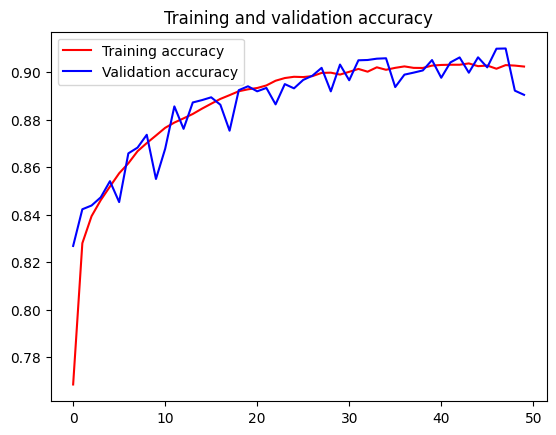

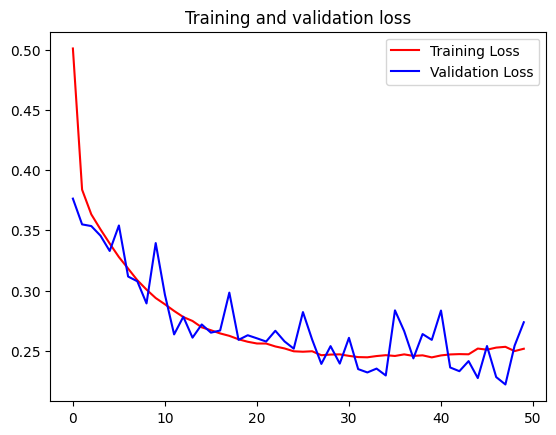

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

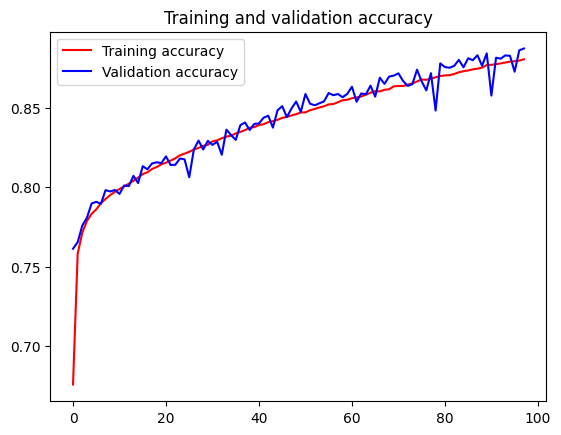

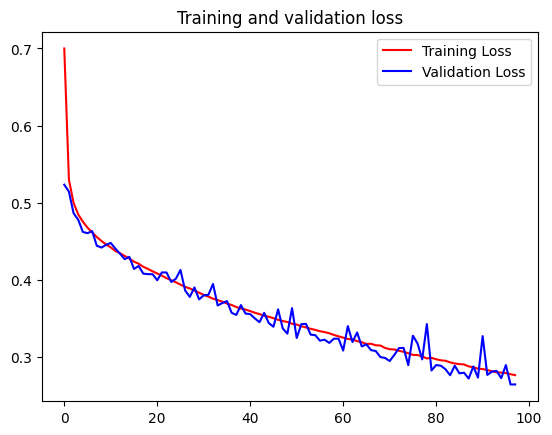

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

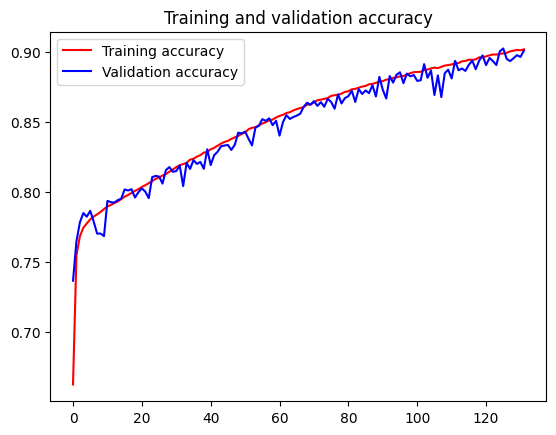

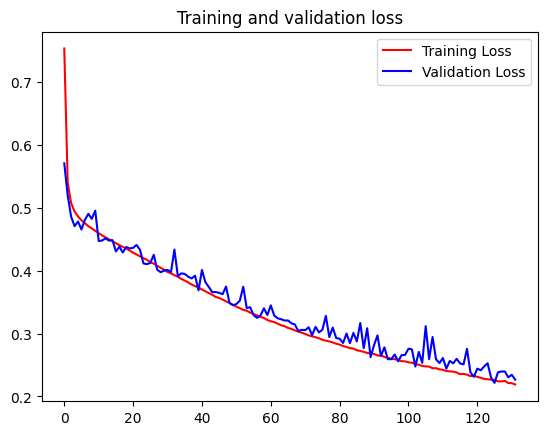

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

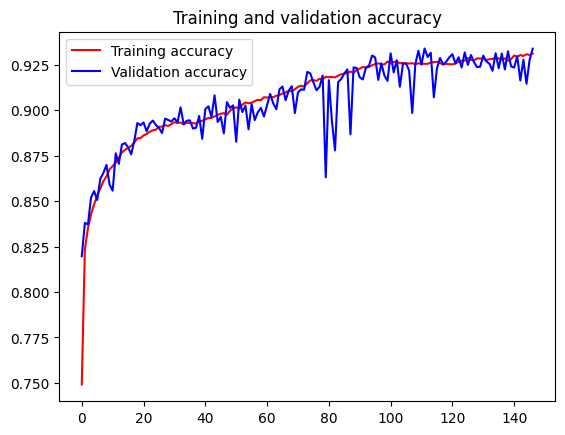

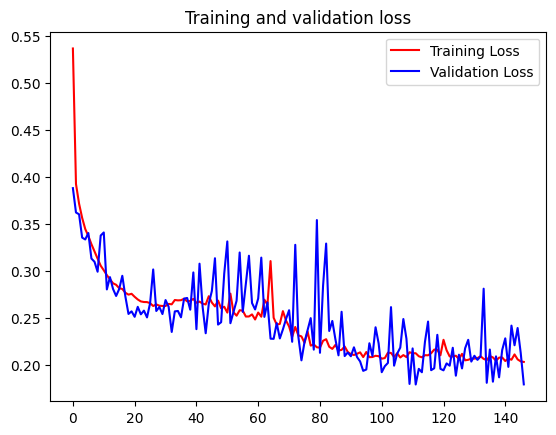

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Untuk prediksi wave P saja

trace_example = preprocess(trace_example, 1, 3)
traces_classic_sta_lta, traces_recursive_sta_lta, traces_envelope, traces_kurtosis, traces_skewness = make_parameters(trace_example, 2, 30, 40)

data_example = {#'trace' : trace_example[0].data,
                'classic STA/LTA' : traces_classic_sta_lta,
                'recursive STA/LTA' : traces_recursive_sta_lta,
                'envelope' : traces_envelope,
                'kurtosis' : traces_kurtosis,
                'skewness' : traces_skewness
                 }

df_example = pd.DataFrame(data_example)
df_example = np.resize(df_example, (df_example.shape[0], 1, df_example.shape[1]))

predict = savedModel.predict(df_example)
predict = np.resize(predict, (predict.shape[1], predict.shape[0]))
idx_predict = predict[0].argmax()

print()
print("Predict to First Break wave-P!")
print()

plt.figure(figsize=(20,8))
plt.subplot(2,1,1)
plt.plot(trace_example[0], label='Trace Example', color='black')
plt.axvline(x= idx_predict, linewidth=1, color='red', label='First break')
plt.legend()
plt.subplot(2,1,2)
plt.plot(predict[0], label='Machine Learning Output', color='black')
plt.legend()
plt.show()

In [ ]:
path_palu = "/content/drive/MyDrive/data/testing/Palu_28-09-2018"
files = os.listdir(path_palu)

In [ ]:
2,3,8,17

13 Trace(s) in Stream:
HK.HKPS..BHZ   | 2018-09-28T10:02:43.019500Z - 2018-09-28T10:14:00.994500Z | 40.0 Hz, 27120 samples
HK.HKPS.00.BHZ | 2018-09-28T10:02:43.019500Z - 2018-09-28T10:14:00.969500Z | 20.0 Hz, 13560 samples
IC.KMI.00.BHZ  | 2018-09-28T10:02:43.019538Z - 2018-09-28T10:15:53.969538Z | 20.0 Hz, 15820 samples
IC.QIZ.00.BHZ  | 2018-09-28T10:02:43.019538Z - 2018-09-28T10:13:31.969538Z | 20.0 Hz, 12980 samples
IC.SSE.00.BHZ  | 2018-09-28T10:02:43.019541Z - 2018-09-28T10:16:09.969541Z | 20.0 Hz, 16140 samples
II.COCO.00.BHZ | 2018-09-28T10:02:43.019538Z - 2018-09-28T10:14:43.994538Z | 40.0 Hz, 28840 samples
II.COCO.10.BHZ | 2018-09-28T10:02:43.019538Z - 2018-09-28T10:14:43.994538Z | 40.0 Hz, 28840 samples
IU.MBWA.00.BHZ | 2018-09-28T10:02:43.019539Z - 2018-09-28T10:13:20.994539Z | 40.0 Hz, 25520 samples
IU.MBWA.10.BHZ | 2018-09-28T10:02:43.019539Z - 2018-09-28T10:13:20.994539Z | 40.0 Hz, 25520 samples
IU.NWAO.00.BHZ | 2018-09-28T10:02:43.019538Z - 2018-09-28T10:16:33.994538Z | 

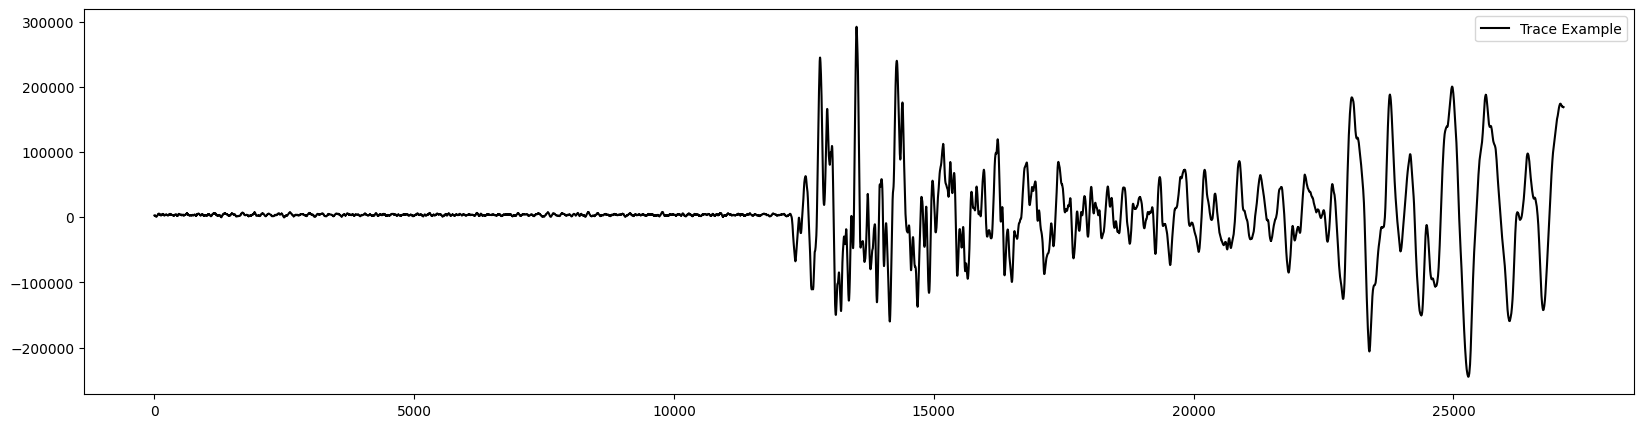

In [ ]:
#trace_example = read(path_palu + '/' + files[87])
trace_example = read("/content/2018-09-28-mww75-minahassa-peninsula-sulawesi_gempaPalu.miniseed")
#t1 = trace_example[0].stats.starttime
#trace_example = trace_example.slice(t1, t1+90)
#trace_example = trace_example.select(id='IU.NWAO.00.BHZ')
print(trace_example)
plt.figure(figsize=(20,5))
plt.plot(trace_example[0], label='Trace Example', color='black')
plt.legend()
plt.show()

#trace_example[0].plot()
#trace_example.spectrogram(log=True, samp_rate=40)
#spec = obspy.signal.freqattributes.spectrum()

In [ ]:
trace_example = preprocess_non_filter(trace_example)
traces_classic_sta_lta, traces_recursive_sta_lta, traces_envelope, traces_kurtosis, traces_skewness = make_parameters(trace_example, 2, 30, 40)

data_example = {'trace' : trace_example[0].data,
                'classic STA/LTA' : traces_classic_sta_lta,
                'recursive STA/LTA' : traces_recursive_sta_lta,
                'envelope' : traces_envelope,
                'kurtosis' : traces_kurtosis,
                'skewness' : traces_skewness
                 }

df_example = pd.DataFrame(data_example)
predict = savedModel.predict(df_example)
arr_predict = np.array([pred.argmax() for pred in predict])

848/848 [==============================] - 6s 6ms/step


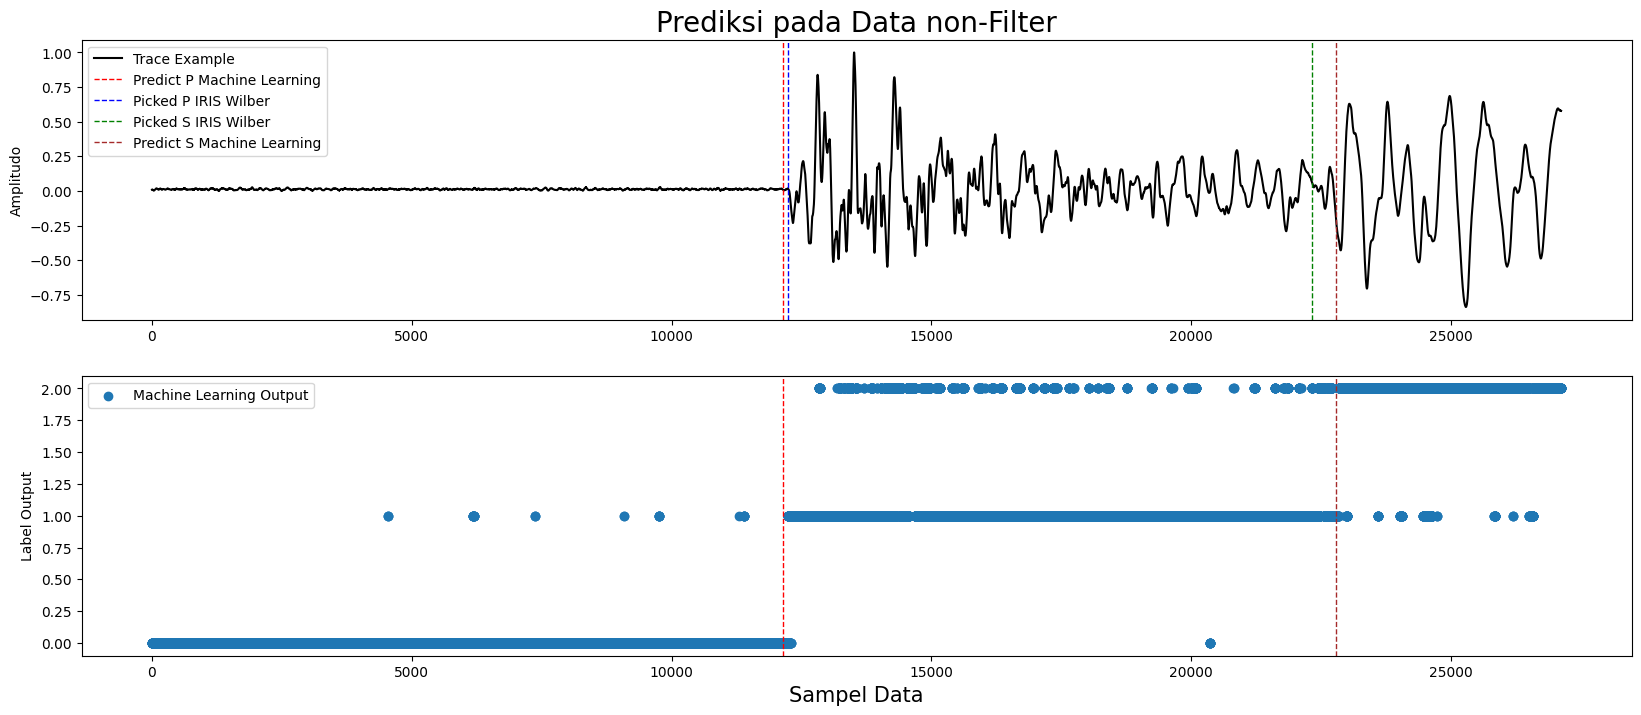

In [ ]:
plt.figure(figsize=(20,8))
plt.subplot(211)

plt.title("Prediksi pada Data non-Filter", fontsize=20)
plt.ylabel("Amplitudo")
plt.plot(trace_example[0].data, label='Trace Example', color='black')
plt.axvline(x= 12150, linewidth=1, color='red', linestyle='--', label='Predict P Machine Learning')
plt.axvline(x= 12240, linewidth=1, color='blue', linestyle='--', label='Picked P IRIS Wilber')
plt.axvline(x= 22320, linewidth=1, color='green', linestyle='--', label='Picked S IRIS Wilber')
plt.axvline(x= 22780, linewidth=1, color='brown', linestyle='--', label='Predict S Machine Learning')
plt.legend(loc='upper left')

plt.subplot(212)
plt.xlabel("Sampel Data", fontsize=15)
plt.ylabel("Label Output")
plt.scatter(np.arange(len(trace_example[0].data)),arr_predict, label='Machine Learning Output')
plt.axvline(x= 12150, linewidth=1, color='red', linestyle='--')
plt.axvline(x= 22780, linewidth=1, color='brown', linestyle='--')
plt.legend(loc='upper left')

plt.show()

In [ ]:
# Predicted Machine Learning
p1 = [12175, 13155, 11170, 15420, 18300, 25970, 18100, 18050, 24550, 29200, 22690, 12600, 27200, 25300]
s1 = [22245, 23960, 20470, 28550, 33100, 47150, 32800, 33000, 44805, 53790, 41750, 23010, 49360, 46050]

In [ ]:
# Picked IRIS Wilber
p2 = [12240, 13240, 11320, 15720, 18320, 26160, 18280, 18080, 24720, 29360, 22820, 12680, 27360, 25400]
s2 = [22320, 24040, 20720, 28440, 33120, 47560, 33040, 32680, 44840, 53720, 41480, 23120, 49480, 46120]

In [ ]:
Tsp = [] ; Tp = []

In [ ]:
for i in range(len(p2)):
  Tp.append(float(10*3600+2*60+43.019500+(p2[i]/40)))
  Tsp.append(float((s2[i]-p2[i])/40))

In [ ]:
data_ori = {'x':Tp, 'y':Tsp}
df = pd.DataFrame(data_ori)

Coefficient : 0.8178062483110632

Intercept : -29575.216845357965

Persamaan Regresi : 0.818x-29575.2

Origin Time : 36164.0876508792 s



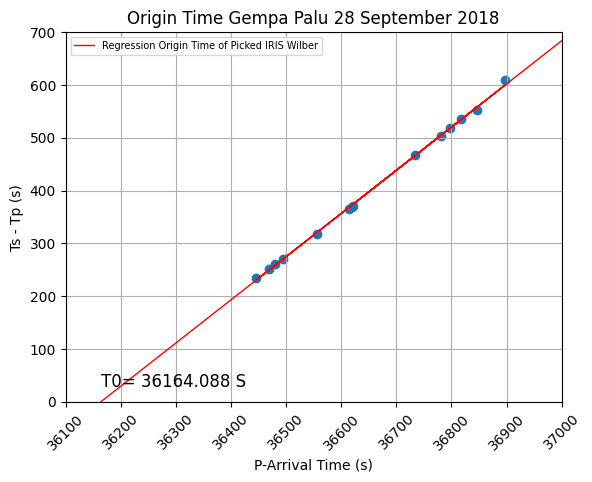

In [ ]:
from sklearn.linear_model import LinearRegression

x_train = df['x'].values[:,np.newaxis]
y_train = df['y'].values
lm = LinearRegression()
lm.fit(x_train,y_train) #fase training
print('Coefficient : ' + str(lm.coef_[0]))
print('\nIntercept : ' + str(lm.intercept_))
print('\nPersamaan Regresi : ' + str(np.round(lm.coef_[0], 3))+'x'+ str(np.round(lm.intercept_, 1)))
t0 = abs(lm.intercept_/lm.coef_)[0]
print('\nOrigin Time : ' + str(t0) + ' s\n')

'''
pb = lm.predict(x_train)
dfc = pd.DataFrame({'x': df['x'],'y':pb})
plt.title("Origin Time Gempa Palu 28 September 2018")
plt.scatter(df['x'],df['y'])
plt.plot(dfc['x'],dfc['y'],color='red',linewidth=1)
plt.xlabel('P-Arrival Time (s)')
plt.xticks(np.arange(36100,37100,100))
plt.yticks(np.arange(0,800,100))
plt.ylabel('Ts - Tp (s)')
plt.grid()
plt.show()
'''
x = df['x'].tolist()
y = df['y'].tolist()

pf = np.polyfit(x, y, 1)
plt.title("Origin Time Gempa Palu 28 September 2018")
plt.scatter(x, y)
xlims = (36100, 37000) ; ylims = (0, 700)
x.insert(0, xlims[0])
y.insert(0, np.polyval(pf, xlims[0]))
x.append(xlims[1])
y.append(np.polyval(pf, xlims[1]))
plt.plot(x, np.polyval(pf,x), 'r-', linewidth = 1, label='Regression Origin Time of Picked IRIS Wilber')
plt.xlim(xlims)
plt.xticks(rotation=45)
plt.ylim(ylims)
plt.xlabel('P-Arrival Time (s)')
plt.ylabel('Ts - Tp (s)')
#plt.text(xlims[0]+10, ylims[1]-10, 'Coefficient: '+str(lm.coef_[0]),
#         color='black', ha='left', va='top', fontsize=8)
plt.text(t0, 20, "T0= "+str(np.round(t0,3))+' S',
         color='black', ha='left', va='bottom', fontsize=12)
plt.legend(fontsize=7)
plt.grid()
plt.show()

In [ ]:
t0

array([-36162.2259724])

In [ ]:
p3

array([ 8.24425462e-01, -2.98130599e+04])

In [ ]:
p3

array([0.9861204 , 0.08237458])

In [ ]:
p1

array([0.9861204 , 0.08237458])

In [ ]:
from obspy.clients.fdsn import Client

In [ ]:
client = Client("IRIS")

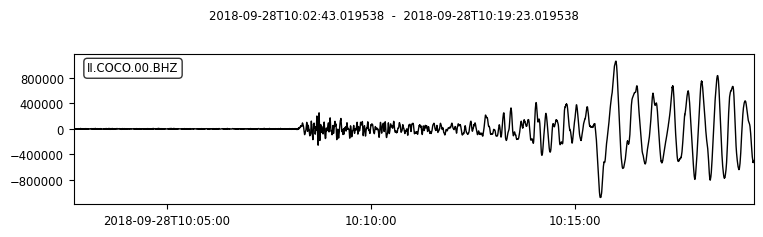

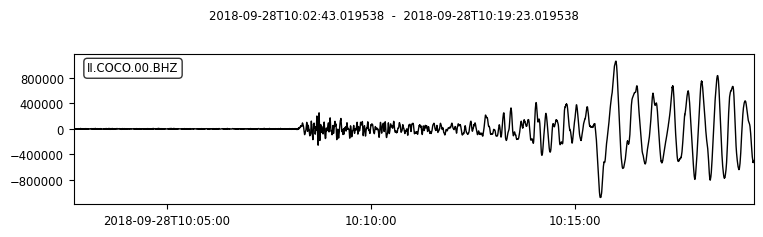

In [ ]:
t = UTCDateTime("2018-09-28T10:02:43.019538Z")
st = client.get_waveforms("II", "COCO", "00", "BHZ", t, t + 1000)
st.plot()

In [ ]:
from obspy.clients.syngine import Client
client = Client()

In [ ]:
st = client.get_waveforms(model="ak135f_5s", network="I*", station="A*",
                          eventid="GCMT:C201002270634A", starttime="P-120", endtime="S+120").resample(40)
st = st.select(id="IQ.APAC.SE.MXZ")
st

1 Trace(s) in Stream:
IQ.APAC.SE.MXZ | 2010-02-27T06:37:03.250000Z - 2010-02-27T06:44:04.975000Z | 40.0 Hz, 16870 samples

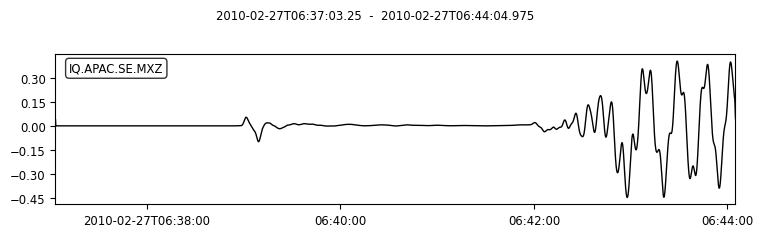

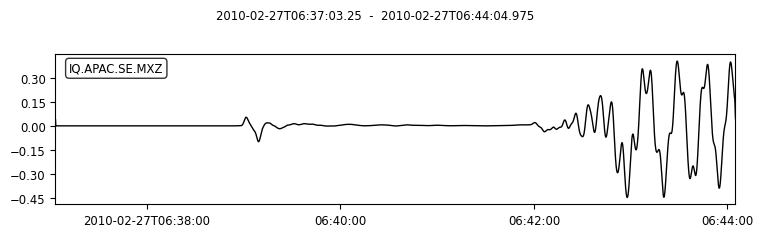

In [ ]:
st.plot()

In [ ]:
st_pre = preprocess_filter(st, 1, 3)

sta = 2
lta = 30



In [ ]:
stream_value, traces_classic_sta_lta, traces_recursive_sta_lta, traces_envelope, traces_kurtosis, traces_skewness = make_parameters(st_pre, sta, lta, 40)

data1 = {#'time' : time_value,
      'trace' : stream_value,
      'classic STA/LTA' : traces_classic_sta_lta,
      'recursive STA/LTA' : traces_recursive_sta_lta,
      'envelope' : envelope,
      'kurtosis' : kurtosis_value,
      'skewness' : skewness_value,
      'label' : label
      }

df1 = pd.DataFrame(data1)

NameError: ignored